## Figure_4_Demonstrating_Bimodality

In [6]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import norm
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import pickle
import diptest
import pyreadr
from numpy.random import normal
from scipy.optimize import minimize
from scipy.optimize import fsolve
from plottable import Table
from plottable import ColumnDefinition
from matplotlib.colors import LinearSegmentedColormap
import ipynb.fs.defs.Functions_EXP_GMM_Base as gmmEXP
import ipynb.fs.defs.Functions_Yang_Social_Learners as slFuncs
import ipynb.fs.defs.Functions_EXP_Data_Cleaning as dataEXP

### Reading the data

In [7]:
data_range = (0.4,0.6)
freyData = dataEXP.readFreyData(range = data_range)
beckerData = dataEXP.readBeckerData(range = data_range)
moriData = dataEXP.readMoriData(range = data_range)

### Defining plotting functions

In [8]:
def plotFrame(ax, data, bins = None, frameStuff = False, label = "", fontsize = 12, legend = False):
    #Data
    y0 = data[(data.influence == 0)]['y']
    y1 = data[(data.influence == 1)]['y']

    # Histograms
    if bins is not None:
        ax.hist(y0, alpha = 0.6, bins = bins[0], density = True, label = "Independent")
        ax.hist(y1, alpha = 0.6, bins = bins[1], density = True, label = "Influenced")
    else:
        ax.hist(y0, alpha = 0.6, bins = 'auto', density = True, label = "Independent")
        ax.hist(y1, alpha = 0.6, bins = 'auto', density = True, label = "Influenced")
    ax.set_xlim(0,1)

    # KDE
    x = np.linspace(0,1,100)
    gauss_kde = sp.stats.gaussian_kde(y0)
    kde0 = gauss_kde.evaluate(x)
    gauss_kde = sp.stats.gaussian_kde(y1)
    kde1 = gauss_kde.evaluate(x)
    ax.plot(x, kde0, color = 'steelblue', linestyle = "--", alpha = 1)
    ax.plot(x, kde1, color = 'saddlebrown', linestyle = ":", alpha = 1)

    # Text
    text_kwargs = dict(ha='left', va='top', fontsize=fontsize)
    ax.annotate(label, (0, 0.9), xycoords = "axes fraction", **text_kwargs)

    # Frame stuff
    if frameStuff:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_yaxis().set_ticks([])

    #legend
    if legend:
        ax.legend()

def plot_func_vertical(ax, func, x, true_args, color = "black"):
    func_vals = slFuncs.full_func(x, func, args = true_args, includeUnstab = True)
    regime_breaks, regime_nums = slFuncs.find_regimes([np.min(x), np.max(x)], func, args = true_args, includeUnstab = True)
    for rb_it in np.arange(len(regime_breaks)-1):
        for rn_it in np.arange(regime_nums[rb_it]):
            if rn_it == 1:
                ax.plot(func_vals[rb_it][rn_it], x, color = color, linewidth = 2, linestyle = "--")
            else:
                ax.plot(func_vals[rb_it][rn_it], x, color = color, linewidth = 2)


def cmapBySign(df, key, positiveIsRed = False):
    y = df[key]
    if np.max(y)*np.min(y) >= 0:
        if (y.iloc[0] > 0 and positiveIsRed) or (y.iloc[0] < 0 and not positiveIsRed):
            redlist = [[0.0,  1.0, 1.0], [1.0,  1.0, 1.0]]
            greenlist = [[0.0,  0.3, 0.3], [1.0,  0.3, 0.3]]
            bluelist = [[0.0,  0.3, 0.3], [1.0,  0.3, 0.3]]
        else:
            redlist = [[0.0,  0.3, 0.3], [1.0,  0.3, 0.3]]
            greenlist = [[0.0,  1.0, 1.0], [1.0,  1.0, 1.0]]
            bluelist = [[0.0,  0.3, 0.3], [1.0,  0.3, 0.3]]
    else:
        #find zero point
        pointZero = (0-np.min(y))/(np.max(y)-np.min(y))
        eps = 0.00001
        redlist = [[0.0,  1.0, 1.0],
                   [pointZero-eps,  1.0, 1.0],         
                   [pointZero,  0.3, 0.3],
                   [pointZero+eps,  0.3, 0.3],
                   [1.0,  0.3, 0.3]]
        greenlist = [[0.0,  0.3, 0.3],
                   [pointZero-eps,  0.3, 0.3],         
                   [pointZero,  1.0, 1.0],
                   [pointZero+eps,  1.0, 1.0],
                   [1.0,  1.0, 1.0]]
        bluelist = [[0.0,  0.3, 0.3],
                   [pointZero-eps,  0.3, 0.3],         
                   [pointZero,  0.3, 0.3],
                   [pointZero+eps,  0.3, 0.3],
                   [1.0,  0.3, 0.3]]
    cdict = {'red': redlist, 'green': greenlist, 'blue': bluelist, 'alpha':  [[0.0,  0.3, 0.3], [1.0,  0.3, 0.3]]}
    if positiveIsRed:
        return LinearSegmentedColormap(key, cdict).reversed()
    else:
        return LinearSegmentedColormap(key, cdict)

### Generating the figure

In [9]:
outputs = [[gmmEXP.fit_Uni_Bim(beckerData[(beckerData.influence == 0)]['y']), gmmEXP.fit_Uni_Bim(beckerData[(beckerData.influence == 1)]['y'], args_bim_init = [0.5, 0.4, 0.2, 0.9, 0.1])],
           [gmmEXP.fit_Uni_Bim(freyData[(freyData.influence == 0)]['y']), gmmEXP.fit_Uni_Bim(freyData[(freyData.influence == 1)]['y'])],
           [gmmEXP.fit_Uni_Bim(moriData[(moriData.influence == 0)]['y']), gmmEXP.fit_Uni_Bim(moriData[(moriData.influence == 1)]['y'])]]

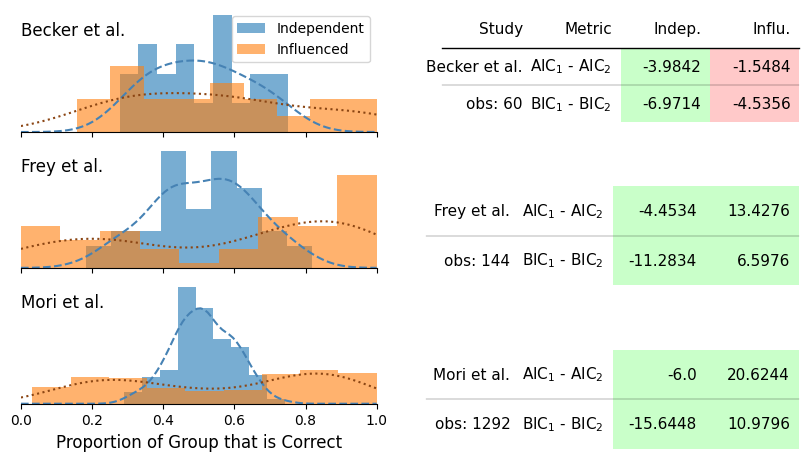

In [10]:
fig = plt.figure(layout='constrained', figsize=(8, 4.5))
subfigs = fig.subfigures(1, 2, wspace=0.07)

# LEFT SIDE
bins = (9, 9)
axsLeft = subfigs[0].subplots(3, 1, sharex = True)
frameStuff = True
plotFrame(axsLeft[0], beckerData, frameStuff = frameStuff, label = "Becker et al.", legend = True, bins = bins)
plotFrame(axsLeft[1], freyData, frameStuff = frameStuff, label = "Frey et al.", bins = bins)
plotFrame(axsLeft[2], moriData, frameStuff = frameStuff, label = "Mori et al.", bins = bins)
axsLeft[-1].set_xlabel("Proportion of Group that is Correct", fontsize = 12)


# RIGHT SIDE
subfigsnest = subfigs[1].subfigures(3, 1, height_ratios = [1,1.3,1.3])

names = [["Becker et al.", f"obs: {len(beckerData['y'])}"], ["Frey et al.", f"obs: {len(freyData['y'])}"], 
         ["Mori et al.", f"obs: {len(moriData['y'])}"]]

axsnest0 = subfigsnest[0].subplots(1, 1)
df = gmmEXP.fitsDataframe([outputs[0]], names)
cmap1 = cmapBySign(df, 'Indep.', True)
cmap2 = cmapBySign(df, 'Influ.')
tab = Table(df, ax = axsnest0, column_border_kw={"linewidth": 1, "linestyle": "-"}, 
            column_definitions=[ColumnDefinition(name="Indep.", cmap=cmap1), ColumnDefinition(name="Influ.", cmap=cmap2)], textprops={"fontsize": 11})

#subfigsnest[1].set_facecolor('aliceblue')
axsnest1 = subfigsnest[1].subplots(1, 1, sharex=True)
df = gmmEXP.fitsDataframe([outputs[1]], [names[1]])
cmap1 = cmapBySign(df, 'Indep.', True)
cmap2 = cmapBySign(df, 'Influ.')
column_definitions = [ColumnDefinition(name = "Study", title=""), ColumnDefinition("Metric", title=""), 
                      ColumnDefinition(name = "Indep.", cmap=cmap1, title=""), ColumnDefinition("Influ.", cmap = cmap2, title="")]
tab = Table(df, ax = axsnest1, col_label_divider = False,
            column_definitions=column_definitions, textprops={"fontsize": 11})

axsnest2 = subfigsnest[2].subplots(1, 1, sharex=True)
df = gmmEXP.fitsDataframe([outputs[2]], [names[2]])
cmap1 = cmapBySign(df, 'Indep.', True)
cmap2 = cmapBySign(df, 'Influ.')
tab = Table(df, ax = axsnest2, col_label_divider = False, column_definitions=column_definitions, textprops={"fontsize": 11})

#plt.savefig("Data and Fit Tables without Macy.png", dpi = 300, bbox_inches = "tight")
plt.show()